<a href="https://colab.research.google.com/github/GodNoob666/GodNoob666.github.io/blob/main/Colab_4_Content_Based_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Preferences: Content-Based Filtering
Predicting user preferences plays a central role in almost every online site. YouTube and Netflix have to recommend vidoes based on what you've liked in the past, Instagram actively decides which posts to prioritize in your feed, and Amazon suggests your next purchase.

In this part of the lesson, we will explore a recommendation algorithm that predicts your preferences based on the attributes of the songs you rated.

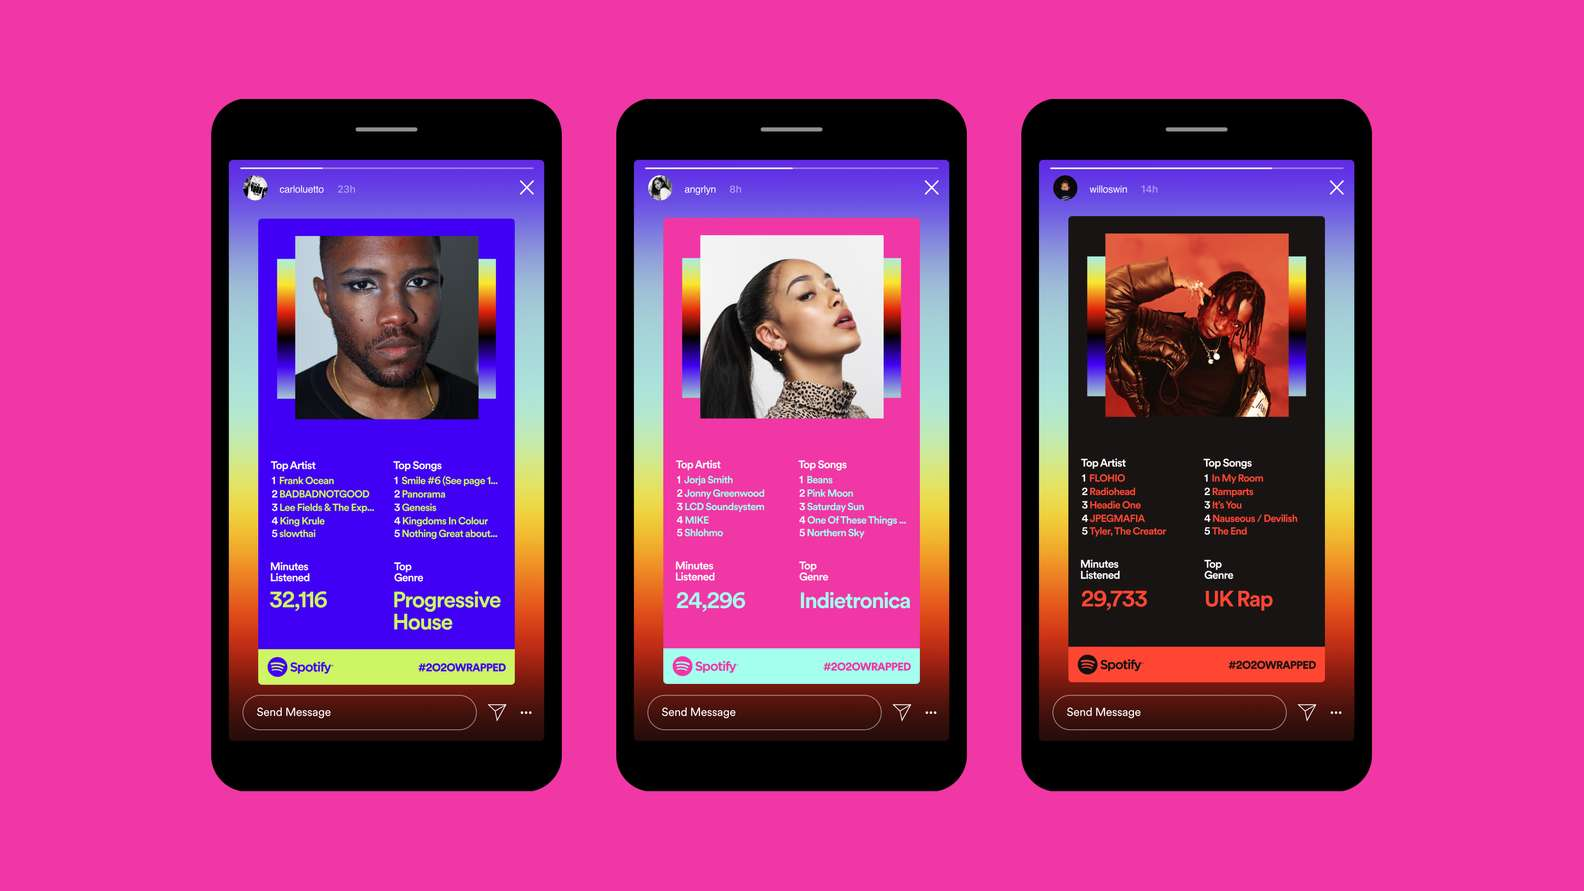

In [1]:
#@title <-- Load imports and functions!

import ast
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from IPython.display import Javascript, display, clear_output
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

LET_TEACHER_PLAY = False

playing_script = \
"""
const audio = new Audio('{url2}');
audio.play();

setTimeout(function() { audio.pause(); }, {playtime});
"""

# Keeps track of songs rated.
num_previewed = 0
songs_rated = pd.DataFrame()

def play_song(song_preview_url, seconds_to_play_for):
  song_player = playing_script.replace("{playtime}", str(seconds_to_play_for * 1000)).replace("{url2}", song_preview_url)
  display(Javascript(song_player))
  if seconds_to_play_for:
    time.sleep(seconds_to_play_for)

# Download dataset
def drive_to_pandas(share_link):
  """ Downloads a CSV in Google drive to a pandas dataframe. """
  download_link = 'https://drive.google.com/uc?export=download&id=' + share_link.split('/')[-2]
  # Finally we use the download link to download our data from the web
  return pd.read_csv(download_link).dropna()

# TODO: Change this to teacher.
# Sample ratings string in case students forget.
sample_ratings = "{'name': 'Ian', 'attributes': ['Beats Per Minute', 'acousticness', 'energy'], 'ratings': [('2YMhrXQYKkm4kXLcXKKd5z', 3.0), ('5HOQNAXcPSwV7Gt8AV8qiP', 7.0), ('1ysjc3rxHEEUGBLhrF8IMn', 8.0), ('0lkQOB949M2gLyut86aJ1b', 8.0), ('7N0mD5y6PRGNjcF8stOKMZ', 5.0), ('2tJulUYLDKOg9XrtVkMgcJ', 6.0), ('448mZKZ9AizlUi3zcaBgD6', 10.0), ('1gKSpFpX3poa17WIAyFVsp', 2.0), ('2xLMifQCjDGFmkHkpNLD9h', 3.0), ('2cbic3TiUENlJX91y67ARR', 7.0), ('22oEJW6r2rMb9z4IntfyEa', 5.0), ('2SBFbElrbcLtfOBcQ2pYdy', 7.0), ('463CkQjx2Zk1yXoBuierM9', 9.0), ('5MVMeTkoRywHlZqrQ8vGOs', 8.0)]}"
import sklearn.preprocessing as preprocessing

def rebuild_songs(forgot=False):
  """Downloads songs dataset and adds student ratings back."""
  songs_rated = drive_to_pandas("https://drive.google.com/file/d/1McQSJDQifk9KAB0zY2k_HE7pPZqWQ7sO/view?usp=sharing")
  songs_rated = songs_rated.set_index("ID")
  export_str = (sample_ratings
                if forgot
                else input("Paste your ratings string from last time: "))
  try:
    rating_imports = ast.literal_eval(export_str)
  except:
    print("Somethings wrong with your input string!")
    print("You can pass 'True' to rebuild songs to use teacher's ratings.")
    return None, None

  # Rebuild ratings.
  actual_ratings = pd.Series(dtype=np.int32)
  for song_id, rating in rating_imports['ratings']:
    actual_ratings[song_id] = rating
  songs_rated['rating'] = actual_ratings
  return songs_rated, rating_imports['attributes'], rating_imports['name']

def output_ratings(songs_rated, name, attributes, train_songnames, test_songnames, content_method_predicted):
  output = {}
  songs_rated = songs_rated.reset_index()
  output['name'] = name
  output['attributes'] = attributes
  output['ratings'] = []

  # Segment dataset in types.
  for _, song in songs_rated.iterrows():
    # Output pure rating tuple.
    rating_tuple = (song['ID'], song['rating'])
    output['ratings'].append(rating_tuple)
    # Also label test vs training set.
    rating_tuple = (song['ID'], song['rating'])

  # Add new train/test songnames
  output['train_songnames'] = list(train_songnames)
  output['test_songnames'] = list(test_songnames)
  print(output)

def model_to_function(model, X_train_cols, attributes):
  """Outputs the model as a function of the form f(x,y,z) = ..."""
  # Output a function of how we predict a songs rating.
  predictors = []
  for importance, attribute in zip(model.coef_, X_train_cols):
    predictors.append(str(round(importance, 2)) + '*' + attribute)
  return "predicted rating = " + " + ".join(predictors) + ' + ' + str(round(model.intercept_, 2))

def build_model(X, y, complexity):
  """Fits and builds a model of a given complexity."""
  # Pull out what the base data set looks like before exponentiating.
  base_x = np.copy(X)
  # Add columns for X**c for each higher complexity.
  for c in range(2, complexity + 1):
    X = np.hstack([X, base_x**c])
  return X, LinearRegression().fit(X, y)



def get_sample_points(X, complexity):
  """Helper that creates sample points across the entire domain."""
  # Create evenly spaced points across the entire range.
  minv = float(np.min(X))
  maxv = float(np.max(X))
  num_steps = (maxv - minv) / 1000
  sample_points = np.arange(minv, maxv, num_steps).reshape(-1, 1)

  # Add higher complexity points as well.
  base_sample_points = np.copy(sample_points)
  for c in range(2, complexity + 1):
    sample_points = np.hstack([sample_points, base_sample_points**c])
  return sample_points

def plot_actual_vs_model(X, y, regression, datatype, X_range = None):
  """Plots 2d actual vs predicted points"""
  # Plot the actual points
  plt.scatter(X, y, c="blue")

  # Get sample points across the entire domain.
  complexity = len(regression.coef_)
  range_values = X if X_range is None else X_range
  sample_points = get_sample_points(range_values, complexity)
  sample_predictions = regression.predict(sample_points)

  # Plot what our model predicts for all X.
  plt.scatter(sample_points[:, 0], sample_predictions, c="red")
  plt.title(f"{datatype} Complexity Level {complexity}")
  plt.show()

def get_points_across_domain(training_dataset, gran=100):
  points = []
  for column in training_dataset:
    dim_lower = float(np.min(training_dataset[column]))
    dim_upper = float(np.max(training_dataset[column]))
    points.append(np.linspace(dim_lower, dim_upper, gran))
  return np.array(np.meshgrid(*points)).T.reshape(-1,training_dataset.shape[1]), points

def get_data_of_complexity(X_train, X_test, X_validation, metrics, model_complexity):
  # Apply normalization.
  # We fit on our training data so that our test data is excluded entirely from biasing training.
  normalizer = preprocessing.StandardScaler().fit(X_train)
  X_train = pd.DataFrame(normalizer.transform(X_train),
                              index=X_train.index, columns=X_train.columns)
  X_test = pd.DataFrame(normalizer.transform(X_test),
                              index=X_test.index, columns=X_test.columns)
  X_validation = pd.DataFrame(normalizer.transform(X_validation),
                              index=X_validation.index, columns=X_validation.columns)

  # Copy only original columns if complexity decreases
  extended_metrics = metrics.copy()
  X_train = X_train[metrics]
  train = X_train.copy()
  X_test = X_test[metrics]
  test = X_test.copy()
  X_validation = X_validation[metrics]
  validation = X_validation.copy()

  for complexity in range(2, model_complexity + 1):
    extended_metrics.extend(
        [f'{x}^{complexity}' for x in metrics])
    X_train = X_train.join(train ** complexity, rsuffix=f'^{complexity}')
    X_test = X_test.join(test ** complexity, rsuffix=f'^{complexity}')
    X_validation = X_validation.join(validation ** complexity, rsuffix=f'^{complexity}')

  return X_train, X_test, X_validation

def analyze_error(model, X_train, X_test, y_train, y_test):
  # Predict the two sets with our model.
  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  # Calculate error.
  train_error = 1 - r2_score(y_train, predicted_train)
  test_error = 1 - r2_score(y_test, predicted_test)
  print(f"Train error: {round(train_error, 3)}")
  print(f"Test error: {round(test_error, 3)}")

def ratings_to_table(title, songnames, model, predictors, actual):
  print(title)
  predicted_ratings = pd.DataFrame()
  predicted_ratings['SongName'] = list(songnames)
  predicted_ratings['Predicted'] = model.predict(predictors)
  predicted_ratings['Actual'] = actual.to_numpy()
  predicted_ratings = predicted_ratings.set_index('SongName')
  return predicted_ratings

# Remove user warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# Import Your Ratings and Attributes
In previous activities you already chose attributes to use in this analysis and rated the songs.

Before running the cell, copy and paste the attributes of your choice in the list called "attributes" (3rd row of code). Remember these are variables so you need to copy them precisely. You can find the variable names in the comment in row 2.

Then run the cell and, when prompted, copy the string that you copied from Colab 1, which you will be able to find in the class spreadsheet.

In [2]:
# Students write their attributes in here.
# all_attributes = ['Acousticness', 'Danceability', 'DurationMs', 'Energy', 'Liveness', 'Loudness', 'Popularity', 'Speechiness', 'Tempo', 'UniqueWords']
attributes = ['DurationMs', 'Popularity', 'Danceability']
 # Enter your attributes here

# Example input : {'name': 'Ian', 'ratings': [('1diS6nkxMQc3wwC4G1j0bh', "We're Good", 3.0), ('4OoYfejHABzYe2mG8p5s8b', 'Higher (feat. iann dior)', 4.0), ('4lyiANCPorBdQ8yGIIwELq', 'Only U', 5.0), ('4w47S36wQGBhGg073q3nt7', 'TKN (feat. Travis Scott)', 4.0), ('66W1rVTnEv86dIkFhoiElg', 'Secrets', 7.0), ('3TVPunYYff1WKCdP68kA03', 'Beating Bold', 6.0), ('0TRmtiR9q6XnYDzXmoMpGC', 'All My Heroes - Radio Edit', 7.0), ('59qrUpoplZxbIZxk6X0Bm3', 'Take You Dancing', 5.0), ('18asYwWugKjjsihZ0YvRxO', 'The Motto', 6.0), ('4i2qxFEVVUi8yOYoxB8TCX', 'Midnight Sky', 5.0), ('0bGH7ezs7WdDwpqnsvGf1z', 'Purple Hat', 5.0), ('3FUTgxlztpSlMqprdqtO8m', 'The Hype', 6.0), ('6muOWhMh7Tf0UFUtMDBhUR', 'Orphans', 5.0), ('5psEZhQu6lukjhavJo4AbC', 'SO DONE', 6.0), ('6IBcOGPsniK3Pso1wHIhew', 'Forever After All', 5.0), ('20VqlVCdPXcPvEnmFvxfxD', 'Something About Her', 6.0), ('2374M0fQpWi3dLnB54qaLX', 'Africa', 5.0), ('70C4NyhjD5OZUMzvWZ3njJ', 'Piano Man', 6.0), ('2tUBqZG2AbRi7Q0BIrVrEj', 'I Wanna Dance with Somebody (Who Loves Me)', 5.0), ('4mn2kNTqiGLwaUR8JdhJ1l', 'House of the Rising Sun', 6.0), ('44AyOl4qVkzS48vBsbNXaC', "Can't Help Falling in Love", 5.0), ('5TDZyWDfbQFQJabbPwImVY', 'Dreams - 2004 Remaster', 6.0), ('7gpy7sfWPNuOKmUNs3XQYE', 'Carry On', 5.0), ('0w07a1vsKahQMM0RnPXHVT', 'Dancing in the Moonlight', 6.0)], 'song_data_url': 'https://drive.google.com/file/d/1AJEfZqi5AxcP7Fu3t-G5UlxlINSVWvCh/view?usp=sharing'}

# Add your ratings back to the dataset!
ratings_string = eval(input('Enter your ratings object from the first activity:'))
student_name = ratings_string['name']
ratings = {}
for rating_tuple in ratings_string['ratings']:
  song_id, song_name, song_rating = rating_tuple
  ratings[song_id] = song_rating

songs_rated = drive_to_pandas(ratings_string['song_data_url'])
songs_rated = songs_rated.set_index('ID')
songs_rated['Rating'] = pd.Series(ratings)
songs_rated = songs_rated.reset_index().set_index('SongName')
songs_rated[['Artist', 'Rating']]

# We will be using your 3 selected attributes to try to predict your ratings.
prediction_factors = songs_rated[attributes]
ratings = songs_rated['Rating']

Enter your ratings object from the first activity:{'name': 'Kaiden St. Dennis', 'ratings': [('1diS6nkxMQc3wwC4G1j0bh', "We're Good", 3), ('4OoYfejHABzYe2mG8p5s8b', 'Higher (feat. iann dior)', 2), ('4lyiANCPorBdQ8yGIIwELq', 'Only U', 3), ('4w47S36wQGBhGg073q3nt7', 'TKN (feat. Travis Scott)', 3), ('66W1rVTnEv86dIkFhoiElg', 'Secrets', 3), ('3TVPunYYff1WKCdP68kA03', 'Beating Bold', 2), ('0TRmtiR9q6XnYDzXmoMpGC', 'All My Heroes - Radio Edit', 3), ('59qrUpoplZxbIZxk6X0Bm3', 'Take You Dancing', 1), ('18asYwWugKjjsihZ0YvRxO', 'The Motto', 2), ('4i2qxFEVVUi8yOYoxB8TCX', 'Midnight Sky', 3), ('0bGH7ezs7WdDwpqnsvGf1z', 'Purple Hat', 2), ('3FUTgxlztpSlMqprdqtO8m', 'The Hype', 4), ('6muOWhMh7Tf0UFUtMDBhUR', 'Orphans', 3), ('5psEZhQu6lukjhavJo4AbC', 'SO DONE', 2), ('6IBcOGPsniK3Pso1wHIhew', 'Forever After All', 4), ('20VqlVCdPXcPvEnmFvxfxD', 'Something About Her', 3), ('2374M0fQpWi3dLnB54qaLX', 'Africa', 8), ('70C4NyhjD5OZUMzvWZ3njJ', 'Piano Man', 10), ('2tUBqZG2AbRi7Q0BIrVrEj', 'I Wanna Dance with S

## Creating the Train/Test Split

In [3]:
# Train/Test split
from sklearn.model_selection import train_test_split
# Split up into training and test dataset.
X_train, X_test, y_train, y_test = train_test_split(
    prediction_factors, ratings, test_size=0.33)

# Separate song names from features.
train_songnames = X_train.index
test_songnames = X_test.index

## Validation Set
Here the code is pulling out a few songs that are neither in the train nor test data so that we can use it once we have finished making the model to evaluate the model's performance.

In [4]:
# Let's create a validation set that we use to evaluate on later
validation_set = drive_to_pandas("https://drive.google.com/file/d/19eL5FwpjP7OBcDvWv2cdq7_wCWirMwF-/view?usp=sharing")
validation_set = validation_set.set_index('PreviewUrl')
validation_song = validation_set.iloc[0:1].reset_index()

# Building up to a multiple attribute model

Our goal in this Colab is to build a model that uses your three chosen attributes of songs as well as your ratings to predict how you might rate new songs. In order to get there, we will start with a smaller case:

## One-Attribute Model
Here we will create a model usuing the first attribute in your list above and your ratings to create a model. You can use the slider to choose the model's complexity. Feel free to run this cell multiple times to find a level of complexity that works well.

(The error is calculated as $1-R^2$, so smaller is better.)

predicted rating = 1.28*DurationMs + 0.81*DurationMs^2 + 2.88
Train error: 0.264
Test error: 0.589


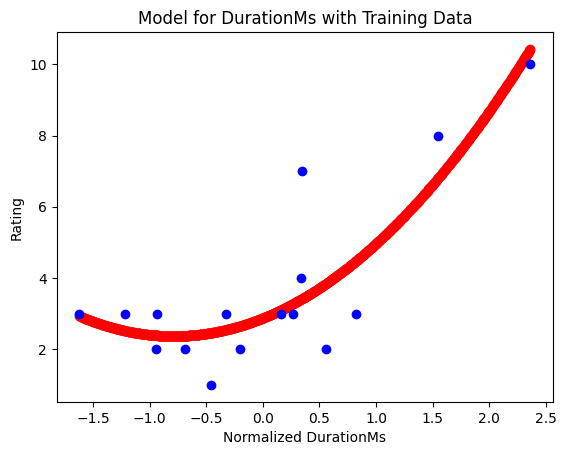

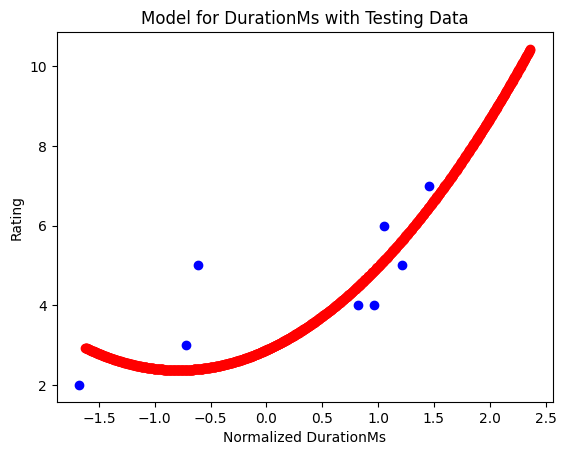

In [18]:
model_complexity_2d = 2 #@param {type:"slider", min:1, max:7, step:1}

# Import
predicting_attribute = attributes[0]
attributes_in_1d_model = [predicting_attribute]
for c in range(2, model_complexity_2d + 1):
    attributes_in_1d_model.append(f'{predicting_attribute}^{c}')

# You can choose a specific attribute here!
X_train_1d, X_test_1d, X_validation_1d = get_data_of_complexity(X_train, X_test, validation_song[attributes], [predicting_attribute], model_complexity_2d)

# Train a 1D model for each attribute.
model_1d = LinearRegression().fit(X_train_1d, y_train)

# Visualize predictions across the domain.
sample_points_1d = get_sample_points(X_train_1d[predicting_attribute], model_complexity_2d)
sample_predicted_1d = model_1d.predict(sample_points_1d)

# Print analysis.
print(model_to_function(model_1d, X_train_1d, attributes_in_1d_model))
analyze_error(model_1d, X_train_1d, X_test_1d, y_train, y_test)

# Plot our model.
plt.scatter(sample_points_1d[:, 0], sample_predicted_1d, c="red")

# Plot real points.
plt.scatter(X_train_1d[predicting_attribute], y_train, c="blue")

# Add title information and show.
plt.title(f"Model for {predicting_attribute} with Training Data")
plt.xlabel(f"Normalized {predicting_attribute}")
plt.ylabel(f"Rating")
plt.show()

# Plot testing data.
sample_points_test = get_sample_points(X_test_1d[predicting_attribute], model_complexity_2d)
sample_predicted_test_1d = model_1d.predict(sample_points_test)
plt.scatter(sample_points_1d[:, 0], sample_predicted_1d, c="red")
plt.scatter(X_test_1d[predicting_attribute], y_test, c="blue")
plt.title(f"Model for {predicting_attribute} with Testing Data")
plt.xlabel(f"Normalized {predicting_attribute}")
plt.ylabel(f"Rating")
plt.show()


### One-Attribute Model Validation
Now that you created a model based on the first attribute, run this cell, listen to a few seconds of the validation song and decide whether you think the rating the model predicts is accurate for you.

In [19]:
# Evaluate on validation song for 1D model.
input('Press enter to see prediction for a validation song:')
validation_song_1d = validation_song.iloc[0]
print(f'Playing {validation_song_1d["SongName"]}')
play_song(validation_song_1d['PreviewUrl'], 5)
print(f"Your model predicts that you would rate the song a {round(model_1d.predict(X_validation_1d)[0],2)}")

Press enter to see prediction for a validation song:
Playing Lose Somebody


<IPython.core.display.Javascript object>

Your model predicts that you would rate the song a 2.58




---


### $\color{red}{\text{STOP HERE}}$


---



## Two-Attribute Model
Now we will add more information to the model, using the first two attributes of your list. Once again, you can use the slider to choose the model's complexity. Notice how our model is now a surface in 3D space!

In [ ]:
model_complexity_3d = 4 #@param {type:"slider", min:1, max:8, step:1}

import plotly.graph_objects as go
from itertools import combinations

# Build our 3D dataset
attribute_a = attributes[0]
attribute_b = attributes[1]
original_attributes = [attribute_a, attribute_b]
attributes_in_2d_model = [attribute_a, attribute_b]
for attribute in original_attributes:
  for c in range(2, model_complexity_3d + 1):
      attributes_in_2d_model.append(f'{attribute}^{c}')


X_train_2d, X_test_2d, X_validation_2d = get_data_of_complexity(X_train, X_test, validation_song[attributes], original_attributes, model_complexity_3d)

model_2d = LinearRegression().fit(X_train_2d, y_train)

# This code just creates points across the entire domain :)
sample_points_1d, dims = get_points_across_domain(X_train_2d[original_attributes])
sample_points = np.copy(sample_points_1d)
for c in range(1, model_complexity_3d):
  sample_points = np.hstack([sample_points, np.power(sample_points_1d, c + 1)])

# Predict with our model!
predicted = model_2d.predict(sample_points)

# Add plane of our predicted ratings.
def visualize_model_3d(predicted):
  # Plot our model.
  fig = go.Figure(data=[go.Surface(z=predicted.reshape((100,100)), x=dims[0], y=dims[1])])
  fig.update_layout(title=f'2D Model using {attribute_a} and {attribute_b}', autosize=True,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90),
                    scene = dict(
                    xaxis_title=attribute_a,
                    yaxis_title=attribute_b,
                    zaxis_title='Predicted Song Rating'))
  return fig

fig = visualize_model_3d(predicted)

# Add original points.
fig.add_trace(dict(type='scatter3d',
              x=X_train_2d[attribute_a],
              y=X_train_2d[attribute_b],
              z=y_train,
              mode='markers'))

print(model_to_function(model_2d, X_train_2d, attributes_in_2d_model))
analyze_error(model_2d, X_train_2d, X_test_2d, y_train, y_test)
fig.show()

#### Visualizing The Model on the Testing Set

In [ ]:
# This code just creates points across the entire domain :)
sample_points_1d, dims = get_points_across_domain(X_train_2d[original_attributes])
sample_points_test = np.copy(sample_points_1d)
for c in range(1, model_complexity_3d):
  sample_points_test = np.hstack([sample_points_test, np.power(sample_points_1d, c + 1)])

# Predict with our model!
predicted_test = model_2d.predict(sample_points_test)
fig = visualize_model_3d(predicted_test)
fig.add_trace(dict(type='scatter3d',
              x=X_test_2d[attribute_a],
              y=X_test_2d[attribute_b],
              z=y_test,
              mode='markers'))

##Two-Attribute Model Validation

Now that we have a two-attribute model, run this cell and once again listen to a few seconds of the validation song and decide whether you think the new rating the model predicts is accurate for you. Is it better or worse than when you were using a single attribute?

In [ ]:
# Evaluate on validation song for 1D model.
input('Press enter to see prediction for a validation song:')
print(f'Playing {validation_song["SongName"]}')
play_song(validation_song.iloc[0]['PreviewUrl'], 5)
print(f"Your model predicts that you would rate the song a {round(model_2d.predict(X_validation_2d)[0],2)}")



---


### $\color{red}{\text{STOP HERE}}$


---



## Three-Attribute Model
Now we will finally use all three attributes you chose. This time, since we have 4 dimensions (three attributes and the ratings) we can no longer visualize it! The process, however, remains the same. You can use the slider to choose the model's complexity, and check the train and test errors to make your decision.

In [ ]:
model_complexity = 1 #@param {type:"slider", min:1, max:5, step:1}
X_train_norm, X_test_norm, X_validation_norm = get_data_of_complexity(X_train, X_test, validation_set[attributes], attributes, model_complexity)
#X_train_norm.head()

# Train our linear regression (least squares!)
model = LinearRegression().fit(X_train_norm, y_train)

# Output a function of how we predict a songs rating.
predictors = []
for importance, attribute in zip(model.coef_, X_train_norm.columns):
  predictors.append(str(round(importance, 2)) + '*' + attribute)
predicting_function = "predicted rating = " + " + ".join(predictors) + ' + ' + str(round(model.intercept_, 2))

# Replace long names with short variables.
for attribute_name, replacement in zip(attributes, ['x','y','z']):
  print(f"{replacement} = {attribute_name}")
  predicting_function = predicting_function.replace(attribute_name, replacement)

print(predicting_function)
print('\n')
analyze_error(model, X_train_norm, X_test_norm, y_train, y_test)
ratings_to_table('Training Set Table', train_songnames, model, X_train_norm, y_train)

x = Tempo
y = UniqueWords
z = Acousticness
predicted rating = 0.41*x + -0.46*y + 0.07*z + 7.19


Train error: 0.858
Test error: 0.806
Training Set Table


,Predicted,Actual
SongName,,
Higher (feat. iann dior),7.377011,4.0
TKN (feat. Travis Scott),5.865029,8.0
All My Heroes - Radio Edit,6.770505,5.0
Something About Her,7.067995,6.0
Purple Hat,7.635529,9.0
The Hype,6.893859,7.0
Orphans,6.891549,8.0
Forever After All,7.144868,7.0
Dancing in the Moonlight,7.792641,9.0


In [ ]:
# Print table of test set.
predicted_test_set = ratings_to_table('Test Set Table', test_songnames, model, X_test_norm, y_test)
predicted_test_set

##Three-Attribute Model Validation

Now that we have a complete model using all three attributes of your choice, let's try a validation with the same song we have been using plus two more. Listen to a portion of the songs and decide whether you think the predicted rating is accurate for you. Is it better or worse than when we were using a fewer attributes?

In [ ]:
# Predict on new set.
input('Press enter to see prediction for validation songs:')
X_validation = X_validation_norm.copy()
X_validation['Predicted'] = model.predict(X_validation_norm)
X_validation['SongName'] = validation_set['SongName']

for preview_url, validation_song in X_validation.iterrows():
  print(f'Playing {validation_song["SongName"]}')
  play_song(preview_url, 5)
  print(f'Your model predicts that you would have rated a {round(float(validation_song["Predicted"]),2)}')

# Export Songs With Content Based Ratings
Run the cell below and copy and paste the output to a form provided by your teacher! This is similar to the string we had before, but now it contains additional information from what we did in this Colab. Once again copy it and submit it to a class form so you can find it later.

In [ ]:
# Add all ratings to a triple.
ratings = []
training_set = set(train_songnames)
for song_name, song in songs_rated.iterrows():
  if song_name in training_set:
    ratings.append((song['ID'], song_name, song['Rating'], True, None))
  else:
    ratings.append((song['ID'], song_name, song['Rating'], False,
                    predicted_test_set.loc[song_name]['Predicted']))

# Put this into an exportable to use object [serialize!].
output = {}
output['name'] = input("What's your name? (First and Last Name): ")
output['ratings'] = ratings
output['song_data_url'] = ratings_string['song_data_url']
clear_output()
print(output)

## Make sure you copied the right thing!

In [ ]:
import ast
copied = input("Repaste: ")
clear_output()
try:
  output = ast.literal_eval(copied)
  assert('name' in output)
  assert('ratings' in output)
  assert('song_data_url' in output)
  assert(len(output['ratings']) > 0)
  assert(len(output['ratings'][0]) == 5)
  print("Copied correctly!")
except:
  print("Did not copy correctly! Make sure that you copy the entire string from '{' to '}'")